Text(0.5,1,'Income distribution in U.S')

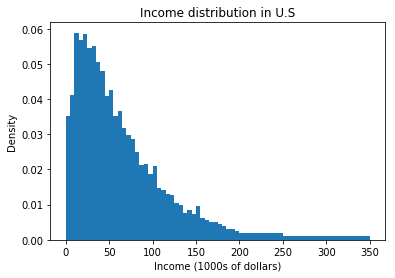

In [10]:
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import scipy.optimize as opt
import math
from scipy.special import gamma
import pandas as pd
import scipy.integrate as integrate

data = pd.read_table("usincmoms.txt", header = None)
data.columns = ["Percent", "Midpoint"]
#scale midpoints to be in 1000s
data.Midpoint = data.Midpoint/1000

#grab weights
wts = data.Percent.copy()

#Fix weights at tail
wts[41] = wts[41]/20
wts[40] = wts[40]/10

#plot
bins = np.append(np.linspace(0, 200, 41), [250, 350])

plt.hist(data.Midpoint, bins = bins, weights=wts)
plt.xlabel("Income (1000s of dollars)")
plt.ylabel("Density")
plt.title("Income distribution in U.S")

In [11]:
#Define Log-normal pdf 
def lognormpdf(x, mu, sigma):
    '''
    lognorm pdf. x >= 0, sigma > 0, mu is any number
    '''
    out = (1 / (x * sigma * np.sqrt(2 * np.pi))) * \
    np.exp(- ((np.log(x) - mu)**2 / (2 * sigma**2)))
    return out

#Define the model moments
def model_moments(mu, sigma):
    '''
    Function computes 42 model moments for generalized 
    method of moments.
    
    Uses method of quadrature to estimate the integrals for
    quantile moments of the lognormal pdf.
    
    Requires you to have a well-defined "bins."
    '''
    N = len(bins)
    moms_mod = np.zeros(N-1)
    for i in range(N-1):
        moms_mod[i] = integrate.quad(lambda x: lognormpdf(x, mu, sigma), bins[i], bins[i+1])[0]
    return moms_mod 

#Define an error function
def err_vec(data, mu, sigma, simple=False):
    '''
    Function computes the vector of moment errors for GMM
    Fits a log-normal distribution.
    
    if simple is true errors are simple difference, if false they
    are perent deviation.
    '''
    moms_data = np.array(data.Percent)
    moms_mod = model_moments(mu, sigma)
    if simple:
        err_vec = moms_mod - moms_data
    else:
        err_vec = (moms_mod - moms_data) / moms_data
    return err_vec

def criterion(params, args):
    '''
    Define criterion function using the L2-norm (sum of squared 
    errors) using given parameters.
    '''
    mu, sigma = params
    data, W = args
    err = err_vec(data, mu, sigma, simple=False)
    crit_val = err.T @ W @ err
    return crit_val

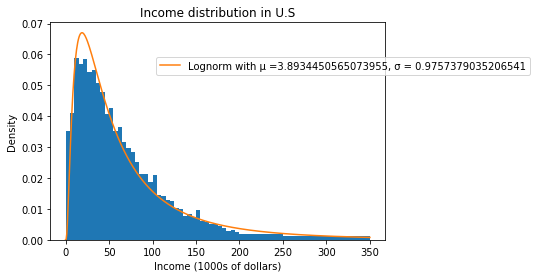

In [12]:
#Perform GMM estimation

#Inital guesses for params
#mean initial guess is log of average mean
mu_guess = np.log(np.sum(data.Percent * data.Midpoint))
#arbitrary sigma initial guess
sig_guess = 1.1
params_init=np.array([mu_guess, sig_guess])

# Define weighting Matrix
W = np.diag(data.Percent)
gmm_args = np.array([data, W])

results = opt.minimize(criterion, params_init, args=gmm_args,  method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
#criterion(params_init, gmm_args)
mu_GMM, sig_GMM = results.x

#print("Error vec", err_vec(data, mu_GMM, sig_GMM))
#print("Model moments", np.sum(model_moments(5, 1)))
#print("Data moments:", np.array(data.Percent))

xgrid = np.linspace(1e-9, 350, 500)
plt.hist(data.Midpoint, bins = bins, weights=wts)
plt.xlabel("Income (1000s of dollars)")
plt.ylabel("Density")
plt.title("Income distribution in U.S")
#Multiply distribution by 5 to account for fact that bins are of width 5
plt.plot(xgrid, 5*lognormpdf(xgrid, mu_GMM, sig_GMM), label = f"Lognorm with μ ={mu_GMM}, σ = {sig_GMM}")
plt.legend(loc='center left', bbox_to_anchor=(.3, 0.8))
error_LN = results.fun

In [26]:
#Define a function for the gamma distribution
def GApdf(x, alpha, beta):
    pdfval = 1/(beta ** alpha * (math.gamma(alpha))) \
             * x ** (alpha- 1) * np.exp(-(x/beta))
    return pdfval

#Implement method from previous problem - define functions:
#Define model_moments
def model_moments(alpha, beta):
    '''
    Function computes 42 model moments for generalized 
    method of moments.
    
    Uses method of quadrature to estimate the integrals for
    quantile moments of the lognormal pdf.
    
    Requires you to have a well-defined "bins."
    '''
    N = len(bins)
    moms_mod = np.zeros(N-1)
    for i in range(N-1):
        moms_mod[i] = integrate.quad(lambda x: GApdf(x, alpha, beta), bins[i], bins[i+1])[0]
    return moms_mod 

#Define an error function
def err_vec(data, alpha, beta, simple=False):
    '''
    Function computes the vector of moment errors for GMM
    Fits a log-normal distribution.
    
    if simple is true errors are simple difference, if false they
    are perent deviation.
    '''
    moms_data = np.array(data.Percent)
    moms_mod = model_moments(alpha, beta)
    if simple:
        err_vec = moms_mod - moms_data
    else:
        err_vec = (moms_mod - moms_data) / moms_data
    return err_vec

def criterion(params, args):
    '''
    Define criterion function using the L2-norm (sum of squared 
    errors) using given parameters.
    '''
    alpha, beta = params
    data, W = args
    err = err_vec(data, alpha, beta, simple=False)
    crit_val = err.T @ W @ err
    return crit_val

1.3670768626860241 48.0617275425839


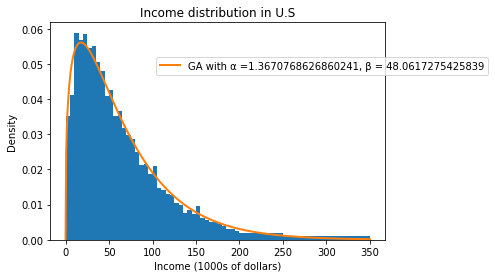

In [27]:
#Perform GMM estimation

#Inital guesses for params
#mean initial guess is log of average mean
alpha_guess = 3
#arbitrary sigma initial guess
beta_guess = 20
params_init=np.array([alpha_guess, beta_guess])

# Define weighting Matrix
W = np.diag(data.Percent)
gmm_args = np.array([data, W])

results = opt.minimize(criterion, params_init,  method='L-BFGS-B', args=gmm_args, bounds=((1e-10, None), (1e-10, None)))
#criterion(params_init, gmm_args)
alpha_GMM, beta_GMM = results.x

#print("Error vec", err_vec(data, mu_GMM, sig_GMM))
#print("Model moments", model_moments(5, 1))
#print("Data moments:", np.array(data.Percent))


xgrid = np.linspace(1e-9, 350, 500)
plt.hist(data.Midpoint, bins = bins, weights=wts)
plt.xlabel("Income (1000s of dollars)")
plt.ylabel("Density")
plt.title("Income distribution in U.S")
plt.plot(xgrid, 5*GApdf(xgrid, alpha_GMM, beta_GMM), label = f"GA with α ={alpha_GMM}, β = {beta_GMM}", linewidth = 2)
plt.legend(loc='center left', bbox_to_anchor=(.3, 0.8), prop = {'size': 10})
error_GA = results.fun
print(alpha_GMM, beta_GMM)